In [ ]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.5 MB/s eta 0:00:00


## [Dependencies]

In [ ]:
import re
import pandas            as pd
import seaborn           as sns
import networkx          as nx
import matplotlib.pyplot as plt

from os                  import walk
from pypdf               import PdfReader
from itertools           import combinations
from tqdm.notebook       import tqdm
from networkx.algorithms import bipartite

## [Dataset creation]

In [ ]:
filenames = next(walk('drive/MyDrive/2024-MO412A-project/files/'), (None, None, []))[2]
all_df = []

for file in tqdm(filenames, total=len(filenames)):
    reader = PdfReader(f'drive/MyDrive/2024-MO412A-project/files/{file}')

    for page in reader.pages:
        text = page.extract_text()

        seq_date_match = re.search(r'Seq:(\d{2}/\d{2}/\d{4})\s+(\d+)', text, re.IGNORECASE)
        materia_match = re.search(r'Seq:\d{2}/\d{2}/\d{4}\s+\d+\n(.+?)\nData:', text, re.S)
        ementa_match = re.search(r'Ementa:\s*(.+?)\s+Descrição:', text, re.S)
        descricao_match = re.search(r'Descrição:\s*(.+?)\s+SENADOR', text, re.S)

        table_pattern = r'^(.+?)\s+([A-Z]{2})\s+([A-Z/]+)\s+([^\n]+)$'
        table_matches = re.findall(table_pattern, text, re.M)

        senador = []
        distrito = []
        partido = []
        voto = []

        for match in table_matches:
            senador.append(match[0])
            distrito.append(match[1])
            partido.append(match[2])
            voto.append(match[3])

        df = pd.DataFrame({
            'senador': senador,
            'distrito': distrito,
            'partido': partido,
            'voto': voto,
            'descricao': descricao_match.group(1).strip() if descricao_match else None,
            'ementa': ementa_match.group(1).strip() if ementa_match else None,
            'materia': materia_match.group(1).strip() + '-' + seq_date_match.group(2).strip() if materia_match else None,
            'data': seq_date_match.group(1).strip() if seq_date_match else None,
            'sequencia': seq_date_match.group(2).strip() if seq_date_match else None
        })

        all_df.append(df)

all_df = pd.concat(all_df, ignore_index=True)
all_df = all_df[all_df.senador != 'SENADOR']
all_df.head(10)

  0%|          | 0/128 [00:00<?, ?it/s]

,senador,distrito,partido,voto,descricao,ementa,materia,data,sequencia
1,Mailza Gomes,AC,PP,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
2,Sérgio Petecão,AC,PSD,P-NRV,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
3,Fernando Collor,AL,PTB,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
4,Renan Calheiros,AL,MDB,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
5,Eduardo Braga,AM,MDB,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
6,Omar Aziz,AM,PSD,P-NRV,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
7,Plínio Valério,AM,PSDB,P-NRV,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
8,Lucas Barreto,AP,PSD,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
9,Randolfe Rodrigues,AP,REDE,Não,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
10,Angelo Coronel,BA,PSD,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1


In [ ]:
print(f'Total de Projetos de Lei: {all_df.materia.nunique()}')
print(f'Total de Senadores:       {all_df.senador.nunique()}')
print(f'Total de Partidos:        {all_df.partido.nunique()}')
print(f'Total de Distritos:       {all_df.distrito.nunique()}')

Total de Projetos de Lei: 125
Total de Senadores:       124
Total de Partidos:        19
Total de Distritos:       27


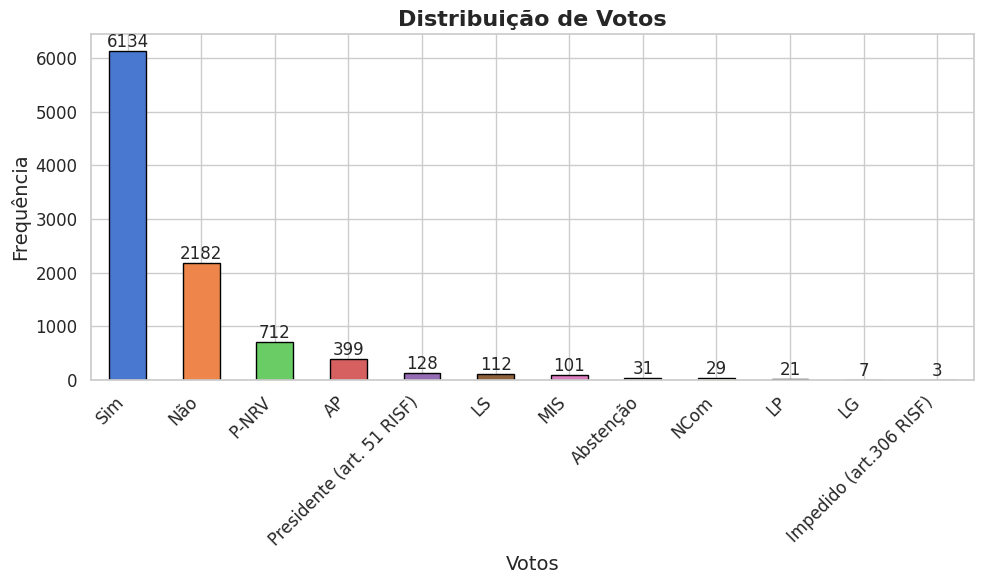

In [ ]:
sns.set_theme(style="whitegrid")

ax = all_df.voto.value_counts().plot(
    kind='bar',
    color=sns.color_palette("muted"),
    figsize=(10, 6),
    edgecolor='black'
)

ax.set_title("Distribuição de Votos", fontsize=16, fontweight='bold')
ax.set_xlabel("Votos", fontsize=14)
ax.set_ylabel("Frequência", fontsize=14)
ax.bar_label(ax.containers[0], fmt='%d', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

In [ ]:
final_df = all_df[(all_df.voto == 'Sim') | (all_df.voto == 'Não') | (all_df.voto == 'Abstenção') | (all_df.voto == 'P-NRV')].copy()
final_df.replace({'Sim': 'Sim', 'Não': 'Não', 'Abstenção': 'Abstenção', 'P-NRV': 'Abstenção'}, inplace=True)
final_df

,senador,distrito,partido,voto,descricao,ementa,materia,data,sequencia
1,Mailza Gomes,AC,PP,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
2,Sérgio Petecão,AC,PSD,Abstenção,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
3,Fernando Collor,AL,PTB,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
4,Renan Calheiros,AL,MDB,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
5,Eduardo Braga,AM,MDB,Sim,"Votação nominal do Projeto de Lei nº 3.846, de...","Altera a Lei nº 11.903, de 14 de janeiro de 20...",PL 3846/2021-1,12/04/2022,1
...,...,...,...,...,...,...,...,...,...
10238,José Aníbal,SP,PSDB,Sim,"Votação nominal da PEC 10, de 2021, em primeir...",Altera o inciso IV do § 2º do art. 4º da Emend...,PEC 10/2021-1,09/12/2021,1
10239,Mara Gabrilli,SP,PSDB,Sim,"Votação nominal da PEC 10, de 2021, em primeir...",Altera o inciso IV do § 2º do art. 4º da Emend...,PEC 10/2021-1,09/12/2021,1
10240,Eduardo Gomes,TO,MDB,Abstenção,"Votação nominal da PEC 10, de 2021, em primeir...",Altera o inciso IV do § 2º do art. 4º da Emend...,PEC 10/2021-1,09/12/2021,1
10241,Irajá,TO,PSD,Sim,"Votação nominal da PEC 10, de 2021, em primeir...",Altera o inciso IV do § 2º do art. 4º da Emend...,PEC 10/2021-1,09/12/2021,1


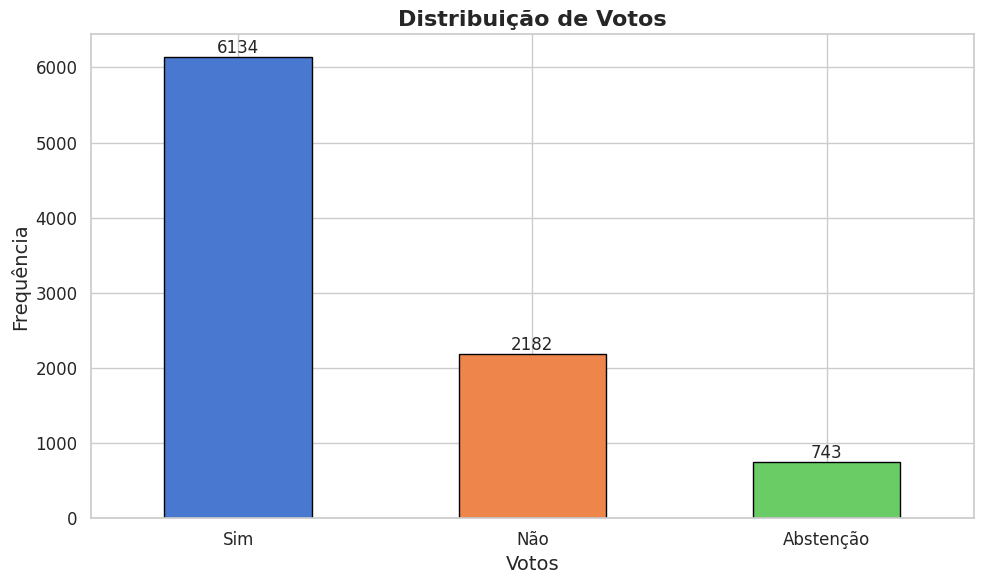

In [ ]:
sns.set_theme(style="whitegrid")

ax = final_df.voto.value_counts().plot(
    kind='bar',
    color=sns.color_palette("muted"),
    figsize=(10, 6),
    edgecolor='black'
)

ax.set_title("Distribuição de Votos", fontsize=16, fontweight='bold')
ax.set_xlabel("Votos", fontsize=14)
ax.set_ylabel("Frequência", fontsize=14)
ax.bar_label(ax.containers[0], fmt='%d', fontsize=12)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

## [Graph Analysis]

### [All information]

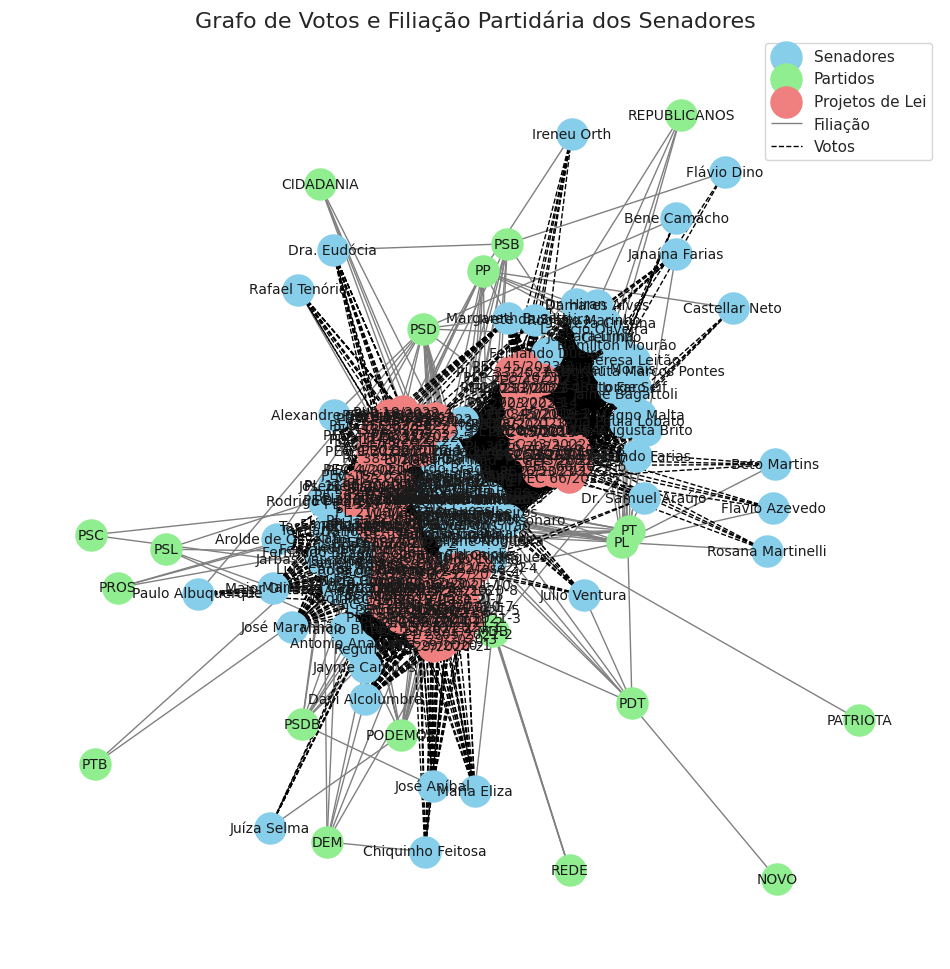

In [ ]:
G = nx.Graph()

for _, row in final_df.iterrows():
    senador = row['senador']
    partido = row['partido']
    materia = row['materia']
    voto    = row['voto']

    G.add_node(senador, tipo='senador')
    G.add_node(partido, tipo='partido')
    G.add_node(materia, tipo='materia')

    G.add_edge(senador, partido, tipo='partido')

    G.add_edge(senador, materia, tipo='voto', voto=voto)

nx.write_gexf(G, 'all_information.gexf')

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))

senadores = [n for n, d in G.nodes(data=True) if d['tipo'] == 'senador']
partidos = [n for n, d in G.nodes(data=True) if d['tipo'] == 'partido']
materias = [n for n, d in G.nodes(data=True) if d['tipo'] == 'materia']

partido_edges = [(u, v) for u, v, d in G.edges(data=True) if d['tipo'] == 'partido']
voto_edges = [(u, v) for u, v, d in G.edges(data=True) if d['tipo'] == 'voto']

nx.draw_networkx_nodes(G, pos, nodelist=senadores, node_color='skyblue', label='Senadores', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=partidos, node_color='lightgreen', label='Partidos', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=materias, node_color='lightcoral', label='Projetos de Lei', node_size=500)

nx.draw_networkx_edges(G, pos, edgelist=partido_edges, edge_color='gray', label='Filiação')
nx.draw_networkx_edges(G, pos, edgelist=voto_edges, edge_color='black', style='dashed', label='Votos')

nx.draw_networkx_labels(G, pos, font_size=10)

plt.legend(scatterpoints=1)
plt.title("Grafo de Votos e Filiação Partidária dos Senadores", fontsize=16)
plt.axis('off')
plt.show()

### [Only Senators]

In [ ]:
votos_por_projeto = final_df.groupby('materia')['senador'].apply(list)

G = nx.Graph()

for _, senadores in votos_por_projeto.items():
    for s1, s2 in combinations(senadores, 2):
        if G.has_edge(s1, s2):
            G[s1][s2]['weight'] += 1
        else:
            G.add_edge(s1, s2, weight=1)

for senador in G.nodes:
    G.nodes[senador]['tipo'] = 'senador'

nx.write_gexf(G, 'only_senators.gexf')

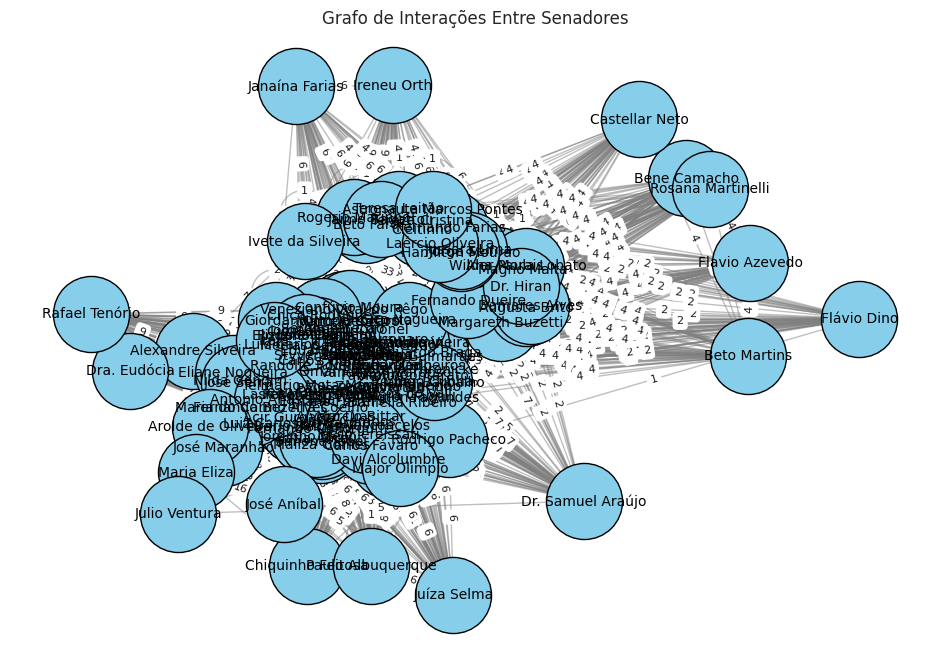

In [ ]:
import matplotlib.pyplot as plt

# Usar o layout Fruchterman-Reingold (bom para redes de interação)
pos = nx.spring_layout(G, seed=42)

# Plotar o grafo
plt.figure(figsize=(12, 8))
edges = nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=3000, node_color='skyblue', edgecolors='black'
)
labels = nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Exibir pesos das arestas (opcional)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo de Interações Entre Senadores")
plt.axis('off')
plt.show()


### [Partidos]

In [ ]:
votos_por_projeto = final_df.groupby('materia')['partido'].apply(list)

G = nx.Graph()

for _, partidos in votos_por_projeto.items():
    for s1, s2 in combinations(partidos, 2):
        if G.has_edge(s1, s2):
            G[s1][s2]['weight'] += 1
        else:
            G.add_edge(s1, s2, weight=1)

for partido in G.nodes:
    G.nodes[partido]['tipo'] = 'partido'

nx.write_gexf(G, 'only_parties.gexf')

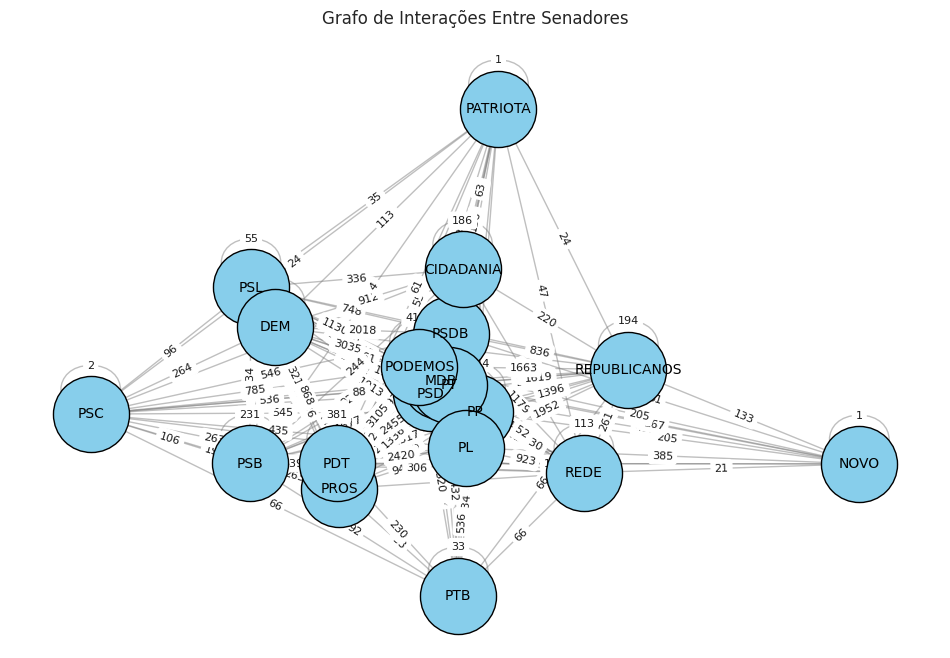

In [ ]:
import matplotlib.pyplot as plt

# Usar o layout Fruchterman-Reingold (bom para redes de interação)
pos = nx.spring_layout(G, seed=42)

# Plotar o grafo
plt.figure(figsize=(12, 8))
edges = nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=3000, node_color='skyblue', edgecolors='black'
)
labels = nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Exibir pesos das arestas (opcional)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo de Interações Entre Senadores")
plt.axis('off')
plt.show()